In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image

import copy
import cv2
import random
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


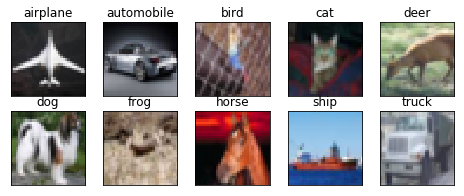

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
import keras.backend as K
def loss_with_reg(model, batch_size, _lambda = 0.001):
  reg_loss_sqr = 0
  for layer in model.layers:
    if len(layer.get_weights()) > 0:
      reg_loss_sqr += np.sum(layer.get_weights()[0]**2)
  reg_loss_sqr = reg_loss_sqr * (_lambda/2*batch_size)
    
  def temp(y_true,y_pred):
    return K.categorical_crossentropy(y_true, y_pred)+reg_loss_sqr
  return temp

# Simple Base model without cut-out
- I have used this model in assignment 6A.


In [8]:
# Define the model
batch_size = 400
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))#32 # Channel Size
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(48, 3, 3))#30
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(64, 3, 3, border_mode='same'))#30
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(MaxPooling2D(pool_size=(2, 2)))#15


model.add(Convolution2D(48, 1, 1))#15
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))#13
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(64, 3, 3, border_mode='same'))#13
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(96, 3, 3, border_mode='same'))#13
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(MaxPooling2D(pool_size=(2, 2)))#6

model.add(Convolution2D(64, 1, 1))#6
model.add(BatchNormalization())
model.add(Activation('relu'))

#model.add(Dropout(0.25))

model.add(Convolution2D(128, 3, 3, border_mode='same'))#6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(128, 3, 3))#4
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))

model.add(Convolution2D(128, 3, 3, border_mode='same'))#4
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.18))



model.add(Convolution2D(10, 4, 4))#1
model.add(Flatten())
model.add(Activation("softmax"))


model_2 = copy.deepcopy(model)


# Compile the model
model.compile(optimizer='adam', loss=loss_with_reg(model,batch_size, _lambda = 0.0025), metrics=['accuracy'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  del sys.path[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Upd

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 48)        192       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)       

### This model reached an accuracy of 85.32%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=125, epochs=100)`
  from ipykernel import kernelapp as app


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
125/125 [==============================] - 74s 590ms/step - loss: 840.5778 - acc: 0.3658 - val_loss: 842.0481 - val_acc: 0.2563
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0024610336.
125/125 [==============================] - 68s 542ms/step - loss: 840.0388 - acc: 0.5613 - val_loss: 840.2938 - val_acc: 0.4785
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0020862309.
125/125 [==============================] - 68s 543ms/step - loss: 839.8218 - acc: 0.6400 - val_loss: 840.6879 - val_acc: 0.4001
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0018105009.
125/125 [==============================] - 68s 544ms/step - loss: 839.6803 - acc: 0.6899 - val_loss: 840.1516 - val_acc: 0.5400
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0015991471.
125/125 [==============================] - 68s 541ms/step - loss: 839.57

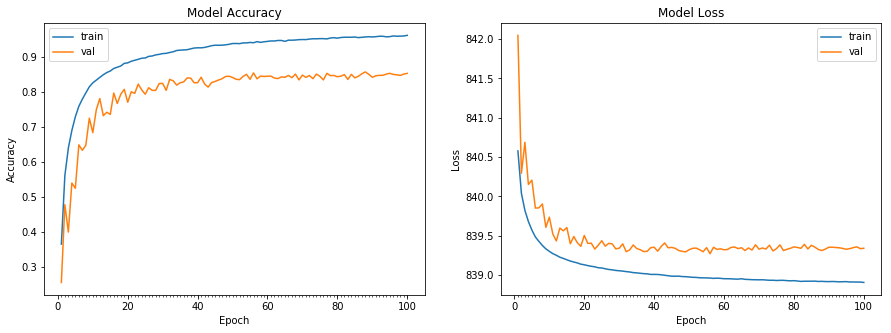

Accuracy on test data is: 85.31


In [0]:
from keras.preprocessing.image import ImageDataGenerator

mcp_save = ModelCheckpoint('./improved.hdf5', save_best_only=True, monitor='val_acc', mode='max')


datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             zoom_range=0.0, 
                             horizontal_flip=True)

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.219 * epoch), 10)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [LearningRateScheduler(scheduler, verbose=1),mcp_save])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))#76 rf 40

In [0]:
model.load_weights("improved.hd5")

## GRAD-CAM (Gradient weighted Class Activation Map Implamentation)

- I sencerely thank [this](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/) blog post for providing support for implemtation.
- With some tweaks In the aove blogs coe I have implemented GRAD-CAM in my code.

### please go through the above blog post .Apart from that i have made the following changes for custom implementation

- ```cv2.imshow()``` does not directly work in colab so i have used matplotlib for plotting image
- Before applying ```cv2.applyColorMap()``` and ```cv2.addWeighted()``` to the image . Image pixels should be converted to a 8 bit integer. Else ```cv2.applyColorMap()``` will throw error
- If we use normal addition for adding image and heatmap. In that scenario if the first image have 250 as pixel value and second have 10 as pixel then effective pixel value will be (250+10)%256 == 4 because pixel value is 8 byte integer. But if we use ```cv2.addWeighted()`` it will handle the overflow value and stop at 255. 

## Grad cam architecture
![gradcamarch](images/gradcamarch.jpg)
## Grad cam sample output
![gradcamsample](images/gradcamsamp.png)

In [0]:
last_layer = -15
predict_labels = model.predict(test_features)
def get_heat_map_images(index, model):
  img = test_features[index]
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.layers[last_layer]
  class_output = model.output[:, class_idx]
  img = test_features[index]
  img = img.copy()
  x = [img]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return img, superimposed_img

## Basic function for plotting normal and GRAD-CAM images 

In [0]:
def plot_images(num_rows, num_cols, indices, model, im_w = 10, im_h = 10):
  fig=plt.figure(figsize=(9, 9))
  
  for v, i in enumerate(indices):
    img, superimposed_img = get_heat_map_images(i,model)
    fig.add_subplot(num_rows,num_cols*2, 2*v+1)
    plt.imshow(img) 
    fig.add_subplot(num_rows,num_cols*2, 2*v+2)
    plt.imshow(superimposed_img) 
  plt.show()


### Observe the below Image is unable to understand the image at all

- Reason could be that the model have assumed that always aeroplane will have white or blue sky in background but here it have green background. Thus failed to recognise. 


> NOTE : I gave a detailed comparision on output image with and without cut-out model in the below cells. Please scroll down. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


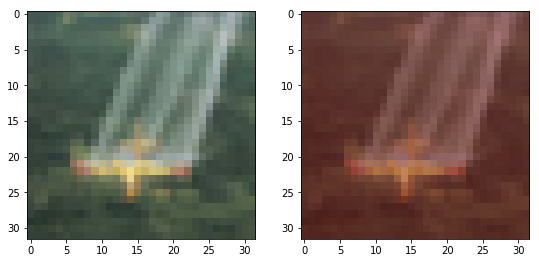

In [24]:
plot_images(1,1,[378], model)

### Below cell calculates the correct and wrongly classified images from base model without cut-out



In [0]:
test_labels_arr = np.argmax(test_labels, axis = 1)
predicted_labels = np.argmax(model.predict(test_features), axis =  1)
mis_classified_indices = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]!=test_labels_arr[i]]
correct_classified_indices = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]==test_labels_arr[i]]
#test_labels

# CUT-OUT Image Augumentation

- Cutout is a kind of image augmentation methods for convolutional neural networks (CNN).
- It try to regularize models using training images that are randomly masked with mean values.

![cut out](images/cutout.png)

### Code Usage

```python
cout_out_function(mean_train, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=False)
```
- __Function Parameters__
  - mean_train : the mean of the pixels over entire dataset. Produced by using below code
  ```
  mean_train = np.mean(train_features,axis = 0)
  ```
  - p : the probability that random erasing is performed
  - s_l, s_h : minimum / maximum proportion of erased area against input image
  - r_1, r_2 : minimum / maximum aspect ratio of erased area
  - v_l, v_h : minimum / maximum value for erased area

> __NOTE__ : I could have simply replaced the cut-out pixels with zero because the mean of normalised image is always zero. But the preprocessing function in image generator executes cutout before normalizing the image. Hence i have replaced the cutout with mean 

In [0]:
mean_train = np.mean(train_features,axis = 0)

def cout_out_function(mean_train, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        # below i have peplaced the cutout area with th mean of the image pixels
        input_img[top:top + h, left:left + w, :] = mean_train[top:top + h, left:left + w, :]

        return input_img

    return eraser


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=125, epochs=100)`


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
125/125 [==============================] - 38s 307ms/step - loss: 839.4656 - acc: 0.3461 - val_loss: 840.7360 - val_acc: 0.2555
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0024610336.
125/125 [==============================] - 34s 273ms/step - loss: 839.0084 - acc: 0.5058 - val_loss: 839.2755 - val_acc: 0.4271
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0020862309.
125/125 [==============================] - 34s 273ms/step - loss: 838.7512 - acc: 0.6007 - val_loss: 838.7261 - val_acc: 0.6113
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0018105009.
125/125 [==============================] - 34s 273ms/step - loss: 838.5972 - acc: 0.6577 - val_loss: 838.7845 - val_acc: 0.5768
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0015991471.
125/125 [==============================] - 34s 272ms/step - loss: 838.49

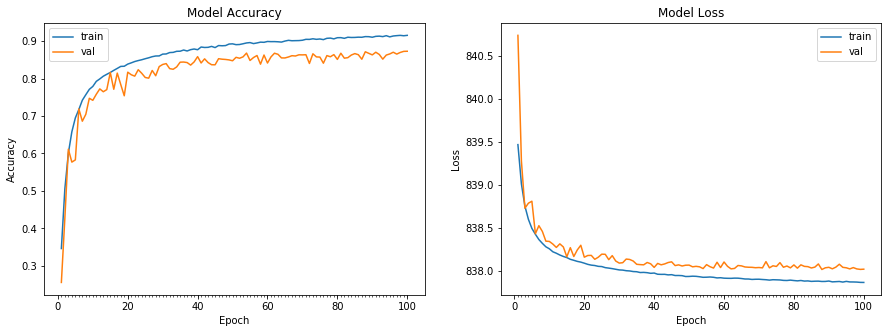

Accuracy on test data is: 87.28


In [0]:
import copy

mcp_save = ModelCheckpoint('./cutout_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model_2.compile(optimizer='adam', loss=loss_with_reg(model_2,batch_size, _lambda = 0.0025), metrics=['accuracy'])
from keras.preprocessing.image import ImageDataGenerator



datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             zoom_range=0.0, 
                             horizontal_flip=True,
                             preprocessing_function = cout_out_function(mean_train, batch_size = batch_size))

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.219 * epoch), 10)
# train the model
start = time.time()
# Train the model
model_info = model_2.fit_generator(datagen.flow(train_features, train_labels, batch_size = batch_size),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks = [LearningRateScheduler(scheduler, verbose=1),mcp_save] )
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model_2))#76 rf 40

In [0]:
model_2.load_weights("cutout_model.hdf5")

### Below cell calculates the correct and wrongly classified images from base model with cut-out.

In [0]:
test_labels_arr = np.argmax(test_labels, axis = 1)
predicted_labels = np.argmax(model_2.predict(test_features), axis =  1)
mis_classified_indices_cutout = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]!=test_labels_arr[i]]
correct_classified_indices_cutout = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]==test_labels_arr[i]]

## Below we can observe that the image is focusing on plane unlike above observation without CUT-OUT

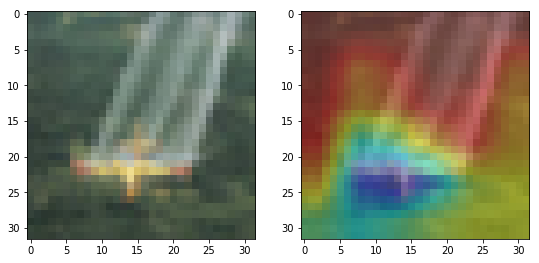

In [23]:
plot_images(1,1,[378], model_2)

__Below code extracts all images which are wrongly classified without cut-out and correctly classified with cut-out .__
- This kind of images will give us more scope to observe the effect of cut-out augumentation of images. Hence extracted those

In [0]:
test_indices = list(set(mis_classified_indices).intersection(set(correct_classified_indices_cutout)))

### I have chosen some random samples from test_indices and using them for camparision

In [0]:
sample_list = [4166,2129,4190,106]

## Samples without CUT-OUT image Agumanetatoin

- We can clearly observe that these images are mis-classified because pf two reasons
  - Eighter they are focusing on background rather than on the image object (Observe the cat in the third image).
  - Or they are focusing on very small part of the image object (Observe the cat in the final image)
- Now let us observe what happends if we use CUT_OUT

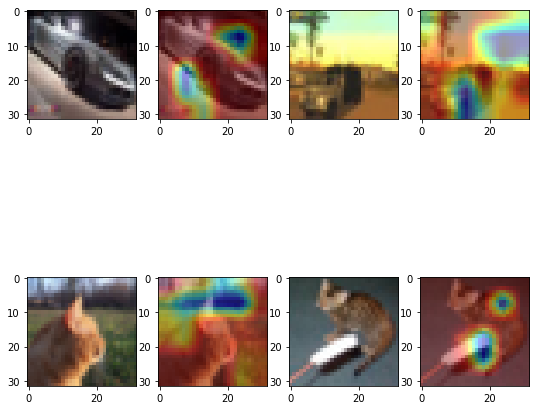

In [79]:
plot_images(2,2,sample_list, model)

## Samples with CUT-OUT Image Augumentation
- We can clearly observe that now the model is focusing on
  - Object in the image not background
  - And covering entire Object. Not just a small part of object

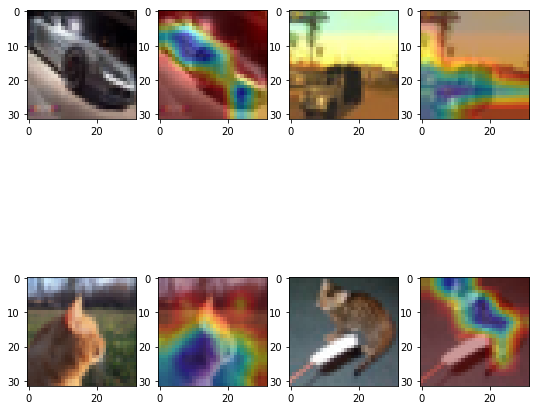

In [80]:
plot_images(2,2,sample_list, model_2)